# 1. Introduction

The purpose of this notebook is to perform cleaning of the Dublin Bus historical data, merge it with weather data, and train a machine learning model.

# 2. Setup & Data Load

Import required modules and packages.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import timedelta
from datetime import datetime
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import xgboost as xgb
import requests as r
import pandas as pd
import seaborn as s
import numpy as np
import googlemaps
import postgres
import holidays
import json
import math

import warnings
warnings.filterwarnings("ignore")

Set the max number of columns & rows to display.

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

Load the bus data from file.

In [2]:
#read section csv
section=pd.read_csv('../clean_data/jun_section.csv')

In [3]:
section.head(10)

,DayOfService,TripID,ProgrNumber,StopPointID,PlannedTime_Arr,ActualTime_Arr,ActualTime_Dep,VehicleID,LineID,RouteID,TripID_2,StopPoint_2,ActualTime_Arr_2,trip_q,TravelTime
0,2018-06-01,6830584,1,248,27600,27628,27628,2868390,14,14_15,6830584,249,27677,0,49
1,2018-06-01,6830584,2,249,27644,27677,27691,2868390,14,14_15,6830584,250,27765,0,74
2,2018-06-01,6830584,3,250,27726,27765,27792,2868390,14,14_15,6830584,251,27838,0,46
3,2018-06-01,6830584,4,251,27774,27838,27870,2868390,14,14_15,6830584,252,27912,0,42
4,2018-06-01,6830584,5,252,27881,27912,27940,2868390,14,14_15,6830584,255,27977,0,37
5,2018-06-01,6830584,6,255,27961,27977,28031,2868390,14,14_15,6830584,234,28077,0,46
6,2018-06-01,6830584,7,234,28038,28077,28121,2868390,14,14_15,6830584,235,28157,0,36
7,2018-06-01,6830584,8,235,28134,28157,28169,2868390,14,14_15,6830584,236,28188,0,19
8,2018-06-01,6830584,9,236,28169,28188,28207,2868390,14,14_15,6830584,1190,28308,0,101
9,2018-06-01,6830584,10,1190,28295,28308,28368,2868390,14,14_15,6830584,1191,28394,0,26


In [4]:
rows = section.shape[0]
cols = section.shape[1]
print()
print("Before any data cleaning, the dataframe contains", rows, "rows and", cols, "columns.")
print()


Before any data cleaning, the dataframe contains 9084685 rows and 15 columns.



In [5]:
section.dtypes

DayOfService        object
TripID               int64
ProgrNumber          int64
StopPointID          int64
PlannedTime_Arr      int64
ActualTime_Arr       int64
ActualTime_Dep       int64
VehicleID            int64
LineID              object
RouteID             object
TripID_2             int64
StopPoint_2          int64
ActualTime_Arr_2     int64
trip_q               int64
TravelTime           int64
dtype: object

### drop useless features

In [6]:
section.drop(columns=['RouteID','PlannedTime_Arr','VehicleID','RouteID','trip_q'], inplace=True)

### add weekday feature, the format of 'DayOfWeek' is that Sunday=1,Monday=2 ... it is more clear to change into Sunday=7, Monday=1 ...

In [7]:
section['DayOfService']=section['DayOfService'].astype('datetime64[ns]')
section['dayOfWeek']=section['DayOfService'].dt.dayofweek
section

,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,TravelTime,dayOfWeek
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,49,4
1,2018-06-01,6830584,2,249,27677,27691,14,6830584,250,27765,74,4
2,2018-06-01,6830584,3,250,27765,27792,14,6830584,251,27838,46,4
3,2018-06-01,6830584,4,251,27838,27870,14,6830584,252,27912,42,4
4,2018-06-01,6830584,5,252,27912,27940,14,6830584,255,27977,37,4
...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,2018-06-30,7115963,52,3114,73959,73959,4,7115963,3115,73986,27,5
9084681,2018-06-30,7115963,53,3115,73986,74002,4,7115963,3116,74041,39,5
9084682,2018-06-30,7115963,54,3116,74041,74041,4,7115963,6085,74129,88,5
9084683,2018-06-30,7115963,55,6085,74129,74141,4,7115963,2026,74201,60,5


In [8]:
section['dayOfWeek']=section['dayOfWeek'].map(lambda day: day+1)

In [9]:
section['dayOfWeek'].value_counts()

5    1696546
2    1404800
3    1382994
4    1349001
6    1282870
1    1226296
7     742178
Name: dayOfWeek, dtype: int64

### holidays

In [11]:
ie_holidays = holidays.Ireland()
section['holiday'] = section["DayOfService"].map(lambda x: x in ie_holidays)

In [12]:
section

,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,TravelTime,dayOfWeek,holiday
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,49,5,False
1,2018-06-01,6830584,2,249,27677,27691,14,6830584,250,27765,74,5,False
2,2018-06-01,6830584,3,250,27765,27792,14,6830584,251,27838,46,5,False
3,2018-06-01,6830584,4,251,27838,27870,14,6830584,252,27912,42,5,False
4,2018-06-01,6830584,5,252,27912,27940,14,6830584,255,27977,37,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,2018-06-30,7115963,52,3114,73959,73959,4,7115963,3115,73986,27,6,False
9084681,2018-06-30,7115963,53,3115,73986,74002,4,7115963,3116,74041,39,6,False
9084682,2018-06-30,7115963,54,3116,74041,74041,4,7115963,6085,74129,88,6,False
9084683,2018-06-30,7115963,55,6085,74129,74141,4,7115963,2026,74201,60,6,False


## stop information

In [13]:
stops=pd.read_csv("../clean_data/stop_info.csv",index_col=0)

In [14]:
stops.head(5)

,StopName,Lat,Lon,StopNumber,routes
0,Parnell Square West,53.352244,-6.263723,2,"['38', '38a', '38b', '46a', '46e']"
1,Parnell Square West,53.352309,-6.263811,3,"['120', '122']"
2,Parnell Square West,53.352575,-6.264175,4,"['7', '7a', '7b', '7d', '9']"
3,Parnell Square West,53.352749,-6.264454,6,"['155', '4']"
4,Parnell Square West,53.352841,-6.264570,7,"['13', '140', '40', '40b', '40d']"


## weather information

In [15]:
weather=pd.read_csv('../clean_data/his_weather_data.csv')

In [16]:
weather

,dt,temp,humidity,wind_speed,clouds,weather_main,extre_weather,datetime
0,1514764800,4.15,87,12.86,40,Rain,0,2018/1/1 0:00
1,1514768400,4.14,87,11.83,75,Rain,0,2018/1/1 1:00
2,1514772000,4.61,81,12.35,40,Clouds,0,2018/1/1 2:00
3,1514775600,4.64,81,12.35,40,Clouds,0,2018/1/1 3:00
4,1514779200,5.04,81,11.83,40,Clouds,0,2018/1/1 4:00
...,...,...,...,...,...,...,...,...
8755,1546282800,9.65,76,4.10,75,Clouds,0,2018/12/31 19:00
8756,1546286400,9.27,81,4.10,75,Clouds,0,2018/12/31 20:00
8757,1546290000,9.31,81,5.10,75,Clouds,0,2018/12/31 21:00
8758,1546293600,9.19,81,5.70,75,Clouds,0,2018/12/31 22:00


In [17]:
weather.count()

dt               8760
temp             8760
humidity         8760
wind_speed       8760
clouds           8760
weather_main     8760
extre_weather    8760
datetime         8760
dtype: int64

### load distance

In [18]:
distance=pd.read_csv("../clean_data/stops_with_distance.csv",index_col=0)

In [19]:
distance.head(5)

,StopPointID,StopPoint_2,distance
0,7347,3669,720.0
1,3669,7349,651.0
2,7349,1631,533.0
3,1631,1632,265.0
4,1632,5053,138.0


### merge section and distance

In [20]:
section=pd.merge(section,distance,how='left',on=['StopPointID','StopPoint_2'])
section

,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,TravelTime,dayOfWeek,holiday,distance
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,49,5,False,193.0
1,2018-06-01,6830584,2,249,27677,27691,14,6830584,250,27765,74,5,False,332.0
2,2018-06-01,6830584,3,250,27765,27792,14,6830584,251,27838,46,5,False,202.0
3,2018-06-01,6830584,4,251,27838,27870,14,6830584,252,27912,42,5,False,327.0
4,2018-06-01,6830584,5,252,27912,27940,14,6830584,255,27977,37,5,False,238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,2018-06-30,7115963,52,3114,73959,73959,4,7115963,3115,73986,27,6,False,257.0
9084681,2018-06-30,7115963,53,3115,73986,74002,4,7115963,3116,74041,39,6,False,470.0
9084682,2018-06-30,7115963,54,3116,74041,74041,4,7115963,6085,74129,88,6,False,508.0
9084683,2018-06-30,7115963,55,6085,74129,74141,4,7115963,2026,74201,60,6,False,489.0


### merge weather and section 

In [21]:
# leavetimes data
# data.plannedARR = data.dayofservice + pd.to_timedelta(data.plannedARR, unit = 'seconds') # in nanoseconds
# data.plannedDEP = data.dayofservice + pd.to_timedelta(data.plannedDEP, unit = 'seconds') # in nanoseconds
section['actualARR'] = section.DayOfService + pd.to_timedelta(section.ActualTime_Arr_2, unit = 'seconds') # in nanoseconds
# data.actualDEP = data.dayofservice + pd.to_timedelta(data.actualDEP, unit = 'seconds') # in nanoseconds

# new columns for combining
# data['time_at_stop'] = data.actualDEP - data.actualARR
section['weather_merge_time'] = section.actualARR.dt.round('H') #  .dt useful
section



,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,TravelTime,dayOfWeek,holiday,distance,actualARR,weather_merge_time
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,49,5,False,193.0,2018-06-01 07:41:17,2018-06-01 08:00:00
1,2018-06-01,6830584,2,249,27677,27691,14,6830584,250,27765,74,5,False,332.0,2018-06-01 07:42:45,2018-06-01 08:00:00
2,2018-06-01,6830584,3,250,27765,27792,14,6830584,251,27838,46,5,False,202.0,2018-06-01 07:43:58,2018-06-01 08:00:00
3,2018-06-01,6830584,4,251,27838,27870,14,6830584,252,27912,42,5,False,327.0,2018-06-01 07:45:12,2018-06-01 08:00:00
4,2018-06-01,6830584,5,252,27912,27940,14,6830584,255,27977,37,5,False,238.0,2018-06-01 07:46:17,2018-06-01 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,2018-06-30,7115963,52,3114,73959,73959,4,7115963,3115,73986,27,6,False,257.0,2018-06-30 20:33:06,2018-06-30 21:00:00
9084681,2018-06-30,7115963,53,3115,73986,74002,4,7115963,3116,74041,39,6,False,470.0,2018-06-30 20:34:01,2018-06-30 21:00:00
9084682,2018-06-30,7115963,54,3116,74041,74041,4,7115963,6085,74129,88,6,False,508.0,2018-06-30 20:35:29,2018-06-30 21:00:00
9084683,2018-06-30,7115963,55,6085,74129,74141,4,7115963,2026,74201,60,6,False,489.0,2018-06-30 20:36:41,2018-06-30 21:00:00


In [22]:
# timestamp convertion 
def convert_timestamp():
    for i, row in weather.iterrows():
        weather.at[i,'datetime']=datetime.fromtimestamp(row['dt'])
    return 

convert_timestamp()
weather['datetime'] = weather['datetime'].astype('datetime64[ns]')

In [23]:
#weather['datetime'] = weather.datetime.dt.round('H') #  .dt useful
weather

,dt,temp,humidity,wind_speed,clouds,weather_main,extre_weather,datetime
0,1514764800,4.15,87,12.86,40,Rain,0,2018-01-01 08:00:00
1,1514768400,4.14,87,11.83,75,Rain,0,2018-01-01 09:00:00
2,1514772000,4.61,81,12.35,40,Clouds,0,2018-01-01 10:00:00
3,1514775600,4.64,81,12.35,40,Clouds,0,2018-01-01 11:00:00
4,1514779200,5.04,81,11.83,40,Clouds,0,2018-01-01 12:00:00
...,...,...,...,...,...,...,...,...
8755,1546282800,9.65,76,4.10,75,Clouds,0,2019-01-01 03:00:00
8756,1546286400,9.27,81,4.10,75,Clouds,0,2019-01-01 04:00:00
8757,1546290000,9.31,81,5.10,75,Clouds,0,2019-01-01 05:00:00
8758,1546293600,9.19,81,5.70,75,Clouds,0,2019-01-01 06:00:00


In [24]:
weather.columns.str.strip()

Index(['dt', 'temp', 'humidity', 'wind_speed', 'clouds', 'weather_main',
       'extre_weather', 'datetime'],
      dtype='object')

In [25]:
weather.head(1)

,dt,temp,humidity,wind_speed,clouds,weather_main,extre_weather,datetime
0,1514764800,4.15,87,12.86,40,Rain,0,2018-01-01 08:00:00


In [26]:
weather.dtypes

dt                        int64
temp                    float64
humidity                  int64
wind_speed              float64
clouds                    int64
weather_main             object
extre_weather             int64
datetime         datetime64[ns]
dtype: object

In [27]:
combinedata = section.merge(weather, 
                         left_on='weather_merge_time', 
                         right_on='datetime', 
                         how='left')

### add hour features

In [28]:
combinedata['hour']=combinedata['actualARR'].dt.hour

In [29]:
combinedata

,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,...,weather_merge_time,dt,temp,humidity,wind_speed,clouds,weather_main,extre_weather,datetime,hour
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,...,2018-06-01 08:00:00,1527811200,13.35,100,3.60,40,Clouds,0,2018-06-01 08:00:00,7
1,2018-06-01,6830584,2,249,27677,27691,14,6830584,250,27765,...,2018-06-01 08:00:00,1527811200,13.35,100,3.60,40,Clouds,0,2018-06-01 08:00:00,7
2,2018-06-01,6830584,3,250,27765,27792,14,6830584,251,27838,...,2018-06-01 08:00:00,1527811200,13.35,100,3.60,40,Clouds,0,2018-06-01 08:00:00,7
3,2018-06-01,6830584,4,251,27838,27870,14,6830584,252,27912,...,2018-06-01 08:00:00,1527811200,13.35,100,3.60,40,Clouds,0,2018-06-01 08:00:00,7
4,2018-06-01,6830584,5,252,27912,27940,14,6830584,255,27977,...,2018-06-01 08:00:00,1527811200,13.35,100,3.60,40,Clouds,0,2018-06-01 08:00:00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,2018-06-30,7115963,52,3114,73959,73959,4,7115963,3115,73986,...,2018-06-30 21:00:00,1530363600,18.88,68,6.17,20,Clouds,0,2018-06-30 21:00:00,20
9084681,2018-06-30,7115963,53,3115,73986,74002,4,7115963,3116,74041,...,2018-06-30 21:00:00,1530363600,18.88,68,6.17,20,Clouds,0,2018-06-30 21:00:00,20
9084682,2018-06-30,7115963,54,3116,74041,74041,4,7115963,6085,74129,...,2018-06-30 21:00:00,1530363600,18.88,68,6.17,20,Clouds,0,2018-06-30 21:00:00,20
9084683,2018-06-30,7115963,55,6085,74129,74141,4,7115963,2026,74201,...,2018-06-30 21:00:00,1530363600,18.88,68,6.17,20,Clouds,0,2018-06-30 21:00:00,20


### save current combinedata

In [30]:
combinedata.to_csv("../clean_data/jun_combinedata_1.csv")

### load current combinedata

In [54]:
import gc
gc.collect()

29701

In [3]:
combinedata=pd.read_csv("../clean_data/jun_combinedata_1.csv",index_col=0)

## clean combine data

In [4]:
combinedata.dtypes

DayOfService           object
TripID                  int64
ProgrNumber             int64
StopPointID             int64
ActualTime_Arr          int64
ActualTime_Dep          int64
LineID                 object
TripID_2                int64
StopPoint_2             int64
ActualTime_Arr_2        int64
TravelTime              int64
dayOfWeek               int64
holiday                  bool
distance              float64
actualARR              object
weather_merge_time     object
dt                      int64
temp                  float64
humidity                int64
wind_speed            float64
clouds                  int64
weather_main           object
extre_weather           int64
datetime               object
hour                    int64
dtype: object

In [5]:
combinedata['DayOfService']=combinedata['DayOfService'].astype('datetime64[ns]')

### 1.drop reduntant features

In [6]:
# drop reduntant rows
combinedata=combinedata[~combinedata['distance'].isnull()]

In [7]:
combinedata.isnull().any()

DayOfService          False
TripID                False
ProgrNumber           False
StopPointID           False
ActualTime_Arr        False
ActualTime_Dep        False
LineID                False
TripID_2              False
StopPoint_2           False
ActualTime_Arr_2      False
TravelTime            False
dayOfWeek             False
holiday               False
distance              False
actualARR             False
weather_merge_time    False
dt                    False
temp                  False
humidity              False
wind_speed            False
clouds                False
weather_main          False
extre_weather         False
datetime              False
hour                  False
dtype: bool

### 3.get the Unique Stopid combinations

In [8]:
# all unique stop combinations for a given lineid.
stop_pairs = combinedata[['StopPointID','StopPoint_2']].drop_duplicates()

print("There are %d unique pairs of stops on line: %s" % (stop_pairs.count()[0], combinedata.LineID.unique()[0]))

There are 6463 unique pairs of stops on line: 14


### 4.get useful features

In [9]:
combinedata.head(1)

,DayOfService,TripID,ProgrNumber,StopPointID,ActualTime_Arr,ActualTime_Dep,LineID,TripID_2,StopPoint_2,ActualTime_Arr_2,...,weather_merge_time,dt,temp,humidity,wind_speed,clouds,weather_main,extre_weather,datetime,hour
0,2018-06-01,6830584,1,248,27628,27628,14,6830584,249,27677,...,2018-06-01 08:00:00,1527811200,13.35,100,3.6,40,Clouds,0,2018-06-01 08:00:00,7


In [10]:
combinedata.columns

Index(['DayOfService', 'TripID', 'ProgrNumber', 'StopPointID',
       'ActualTime_Arr', 'ActualTime_Dep', 'LineID', 'TripID_2', 'StopPoint_2',
       'ActualTime_Arr_2', 'TravelTime', 'dayOfWeek', 'holiday', 'distance',
       'actualARR', 'weather_merge_time', 'dt', 'temp', 'humidity ',
       'wind_speed ', 'clouds ', 'weather_main', 'extre_weather', 'datetime',
       'hour'],
      dtype='object')

In [11]:
dataset=combinedata[['hour','StopPointID','StopPoint_2','dayOfWeek','holiday','distance','temp','humidity ','wind_speed ','clouds ','weather_main','extre_weather','TravelTime']]

In [12]:
dataset

,hour,StopPointID,StopPoint_2,dayOfWeek,holiday,distance,temp,humidity,wind_speed,clouds,weather_main,extre_weather,TravelTime
0,7,248,249,5,False,193.0,13.35,100,3.60,40,Clouds,0,49
1,7,249,250,5,False,332.0,13.35,100,3.60,40,Clouds,0,74
2,7,250,251,5,False,202.0,13.35,100,3.60,40,Clouds,0,46
3,7,251,252,5,False,327.0,13.35,100,3.60,40,Clouds,0,42
4,7,252,255,5,False,238.0,13.35,100,3.60,40,Clouds,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084680,20,3114,3115,6,False,257.0,18.88,68,6.17,20,Clouds,0,27
9084681,20,3115,3116,6,False,470.0,18.88,68,6.17,20,Clouds,0,39
9084682,20,3116,6085,6,False,508.0,18.88,68,6.17,20,Clouds,0,88
9084683,20,6085,2026,6,False,489.0,18.88,68,6.17,20,Clouds,0,60


In [13]:
dataset.dtypes

hour               int64
StopPointID        int64
StopPoint_2        int64
dayOfWeek          int64
holiday             bool
distance         float64
temp             float64
humidity           int64
wind_speed       float64
clouds             int64
weather_main      object
extre_weather      int64
TravelTime         int64
dtype: object

In [14]:
# Note: travel time is continuous but is needed for comparison
categorical_features = ['hour','holiday', 'dayOfWeek','weather_main','extre_weather']

continuous_features  = ['TravelTime','distance','temp','wind_speed ','clouds ','humidity ']

In [15]:
corr = combinedata[continuous_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,TravelTime,distance,temp,wind_speed,clouds,humidity
TravelTime,1.00,0.53,-0.02,0.00,-0.00,0.02
distance,0.53,1.00,0.00,0.00,-0.00,-0.00
temp,-0.02,0.00,1.00,0.15,-0.04,-0.76
wind_speed,0.00,0.00,0.15,1.00,0.16,-0.34
clouds,-0.00,-0.00,-0.04,0.16,1.00,0.09
humidity,0.02,-0.00,-0.76,-0.34,0.09,1.00


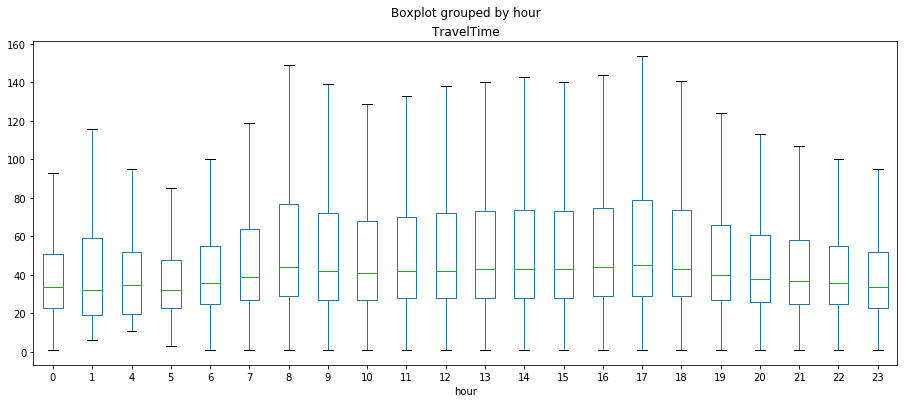

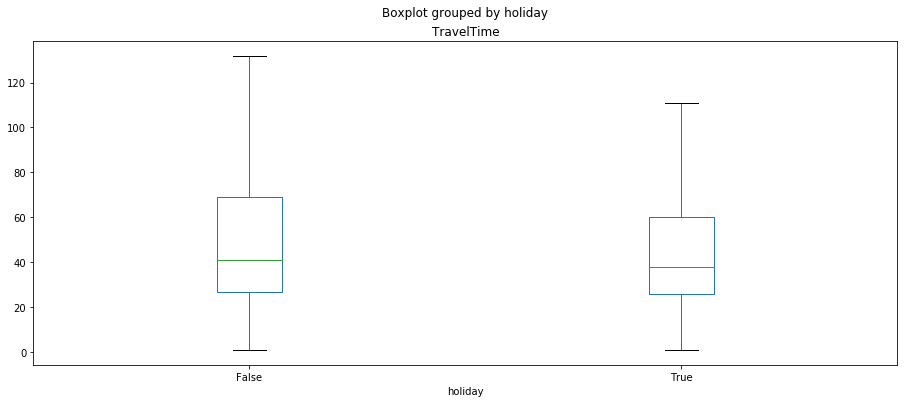

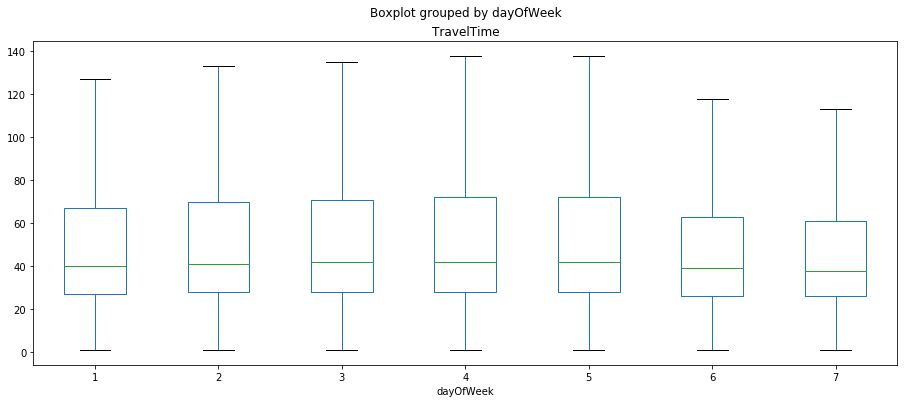

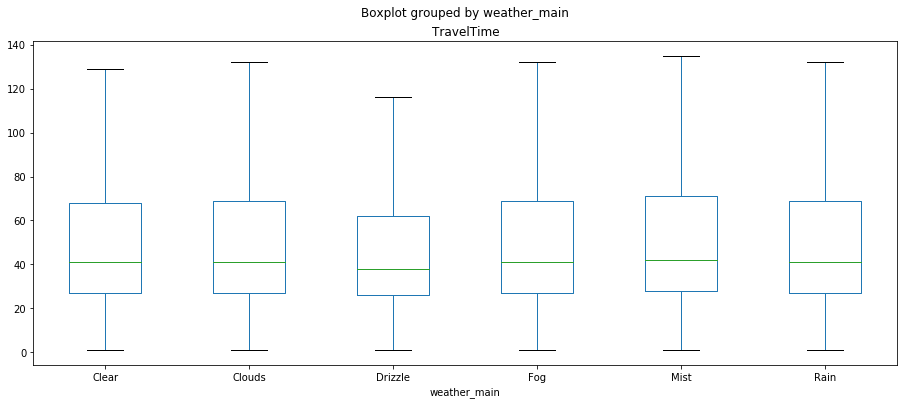

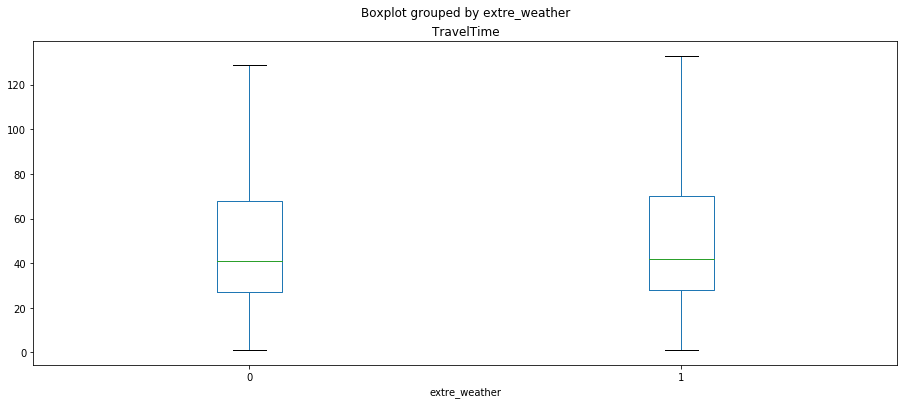

In [16]:
for cat_ft in categorical_features:
    combinedata.boxplot(column=['TravelTime'], by=cat_ft, grid=False, figsize=(15,6), showfliers=False)
    plt.show()

### 5. Set up dummy features.

In [17]:
# set up dummies features
dataset = pd.get_dummies(dataset)
dataset.dtypes

hour                      int64
StopPointID               int64
StopPoint_2               int64
dayOfWeek                 int64
holiday                    bool
distance                float64
temp                    float64
humidity                  int64
wind_speed              float64
clouds                    int64
extre_weather             int64
TravelTime                int64
weather_main_Clear        uint8
weather_main_Clouds       uint8
weather_main_Drizzle      uint8
weather_main_Fog          uint8
weather_main_Mist         uint8
weather_main_Rain         uint8
dtype: object

### uniform the weather main features

In [18]:
dataset.columns

Index(['hour', 'StopPointID', 'StopPoint_2', 'dayOfWeek', 'holiday',
       'distance', 'temp', 'humidity ', 'wind_speed ', 'clouds ',
       'extre_weather', 'TravelTime', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Mist', 'weather_main_Rain'],
      dtype='object')

In [19]:
dataset['weather_main_Snow']=0

In [20]:
order=['hour',
 'StopPointID',
 'StopPoint_2',
 'dayOfWeek',
 'holiday',
 'distance',
 'temp',
 'humidity ',
 'wind_speed ',
 'clouds ',
 'extre_weather',
 'TravelTime',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Snow']
dataset=dataset[order]

### separate the dataset because of the lack of memory

In [21]:
dataset_random=dataset.sample(frac=0.5)

In [22]:
# need to put this in a loop over the pairs of stops. (unique)
target = ['TravelTime']

predictors=[]
for col in dataset.columns:
    predictors.append(col)
  
predictors.remove('TravelTime')
# predictors.remove('LineID')
predictors

['hour',
 'StopPointID',
 'StopPoint_2',
 'dayOfWeek',
 'holiday',
 'distance',
 'temp',
 'humidity ',
 'wind_speed ',
 'clouds ',
 'extre_weather',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Snow']

In [23]:
print("There are %d rows in model data" % (dataset_random.count()[0]))
print("Average Travel Time between stops: {}".format(dataset_random.TravelTime.mean()))

There are 4522978 rows in model data
Average Travel Time between stops: 59.71923254988196


### 6.iltering outliers

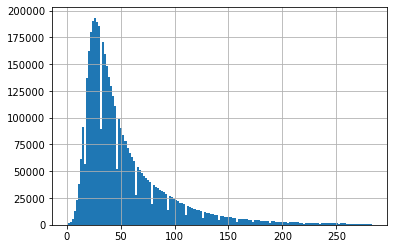

In [24]:
travel_time_deviation = dataset_random.TravelTime.std()

# Filter outliers from the dataset
General_dataset = dataset_random[abs(dataset_random.TravelTime-dataset_random.TravelTime.mean()) < 3*travel_time_deviation]

# Show spread of data
General_dataset.TravelTime.hist(bins=150)

### 6.Train models

In [25]:
# ========================= Test/Train Splits ========================== #
X_train, X_test, y_train, y_test = train_test_split(General_dataset[predictors],
                                                     General_dataset[target].values.ravel(), 
                                                     test_size=0.3, 
                                                     shuffle=True)
print("original range is: ",General_dataset.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  4466326
training range (70%):	 rows 0 to 3126428
test range (30%): 	 rows 3126428 to 4466326


[22:51:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree_method: gpu_histeta } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-rmse:50.55775
Will train until Test-rmse hasn't improved in 100 rounds.
[5]	Test-rmse:23.71618
[10]	Test-rmse:21.63234
[15]	Test-rmse:21.18603
[20]	Test-rmse:21.04187
[25]	Test-rmse:20.93599
[30]	Test-rmse:20.89062
[35]	Test-rmse:20.85563
[40]	Test-rmse:20.84005
[45]	Test-rmse:20.83817
[50]	Test-rmse:20.83543
[55]	Test-rmse:20.83703
[60]	Test-rmse:20.84162
[65]	Test-rmse:20.84532
[70]	Test-rmse:20.85598
[75]	Test-rmse:20.86930
[80]	Test-rmse:20.88577
[85]	Test-rmse:20.89861
[90]	Test-rmse:20.91267
[95]	Test-rmse:20.92702
[100]	Test-rmse:20.94018
[105]	Test-rmse:20.95089
[110]	Test-r

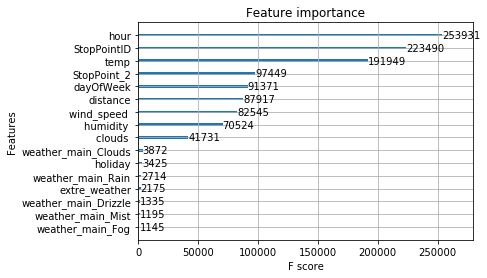

In [26]:
# ========================== Making DMatrices ========================== #
General_dtrain = xgb.DMatrix(X_train, label=y_train)
General_dtest = xgb.DMatrix(X_test, label=y_test)

# =========================== Training Model =========================== #

param = {
    'tree_method: gpu_hist'
    'eta':0.05,
    'max_depth':15
}
num_rounds = 10000

General_model = xgb.train(param, General_dtrain, num_rounds, evals=[(General_dtest, 'Test')], verbose_eval=5, early_stopping_rounds=100)

# ============================  Predictions ============================ #
General_xgbpreds = General_model.predict(General_dtest)

# ====================== Feature Importance graph ====================== #
xgb.plot_importance(General_model)


In [27]:
General_model.save_model('../model/General_6.model')

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, General_xgbpreds)
print("r2: %.2f%%" % (r2 * 100.0))

r2: 74.30%


In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, General_xgbpreds)
print("mse: %.2f%%" % (mse))

mse: 443.95%


## Evaluate Models

### General Model

#### Plotting Errors

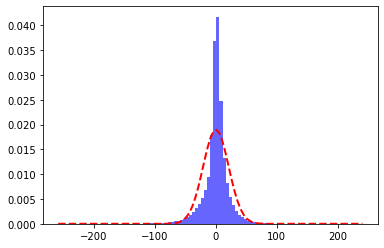

21.07000432080686 0.016598466373498447


In [30]:
import scipy
# ========================= Visualising Errors ========================= #
General_xgbresiduals = General_xgbpreds - y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(General_xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(General_xgbresiduals, 100, density=True, facecolor='blue', alpha=0.6)

# add a 'best fit' line
xy = scipy.stats.norm.pdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

#### Cross Validation

In [31]:
General_rmse = np.sqrt(metrics.mean_squared_error(General_xgbpreds, y_test))

print(f"""
General Model RMSE: {General_rmse}
""")



General Model RMSE: 21.070010858751502



# linear regression model

select 60% dataset

In [118]:
dataset_random=dataset.sample(frac=0.6)

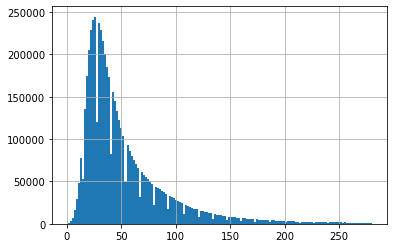

In [119]:
travel_time_deviation = dataset_random.TravelTime.std()

# Filter outliers from the dataset
General_dataset = dataset_random[abs(dataset_random.TravelTime-dataset_random.TravelTime.mean()) < 3*travel_time_deviation]

# Show spread of data
General_dataset.TravelTime.hist(bins=150)

In [120]:
# ========================= Test/Train Splits ========================== #
X_train, X_test, y_train, y_test = train_test_split(General_dataset[predictors],
                                                     General_dataset[target].values.ravel(), 
                                                     test_size=0.3, 
                                                     shuffle=True)
print("original range is: ",General_dataset.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  5552932
training range (70%):	 rows 0 to 3887052
test range (30%): 	 rows 3887052 to 5552932


In [121]:
from sklearn.linear_model import LinearRegression

### training the linear regression

In [122]:
# =========================== Training Model =========================== #

general_linreg = LinearRegression().fit(X_train, y_train)

# ============================  Predictions ============================ #
y_predict = general_linreg.predict(X_test)


### evaluate the model

In [123]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_predict)
print("r2: %.2f%%" % (r2 * 100.0))

r2: 29.37%


In [124]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_predict)
print("mse: %.2f%%" % (mse))

mse: 1166.93%


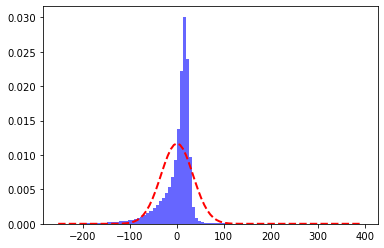

34.160391564336685 -0.011934744646832014


In [125]:
import scipy
# ========================= Visualising Errors ========================= #
General_xgbresiduals = y_predict - y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(General_xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(General_xgbresiduals, 100, density=True, facecolor='blue', alpha=0.6)

# add a 'best fit' line
xy = scipy.stats.norm.pdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

# ridge algorithm

In [126]:
dataset_random=dataset.sample(frac=0.6)

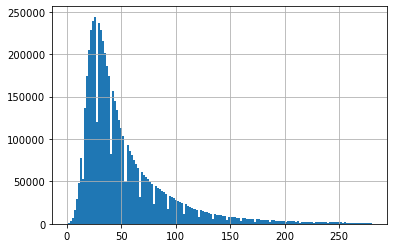

In [127]:
travel_time_deviation = dataset_random.TravelTime.std()

# Filter outliers from the dataset
General_dataset = dataset_random[abs(dataset_random.TravelTime-dataset_random.TravelTime.mean()) < 3*travel_time_deviation]

# Show spread of data
General_dataset.TravelTime.hist(bins=150)

In [128]:
# ========================= Test/Train Splits ========================== #
X_train, X_test, y_train, y_test = train_test_split(General_dataset[predictors],
                                                     General_dataset[target].values.ravel(), 
                                                     test_size=0.3, 
                                                     shuffle=True)
print("original range is: ",General_dataset.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  5552717
training range (70%):	 rows 0 to 3886901
test range (30%): 	 rows 3886901 to 5552717


In [129]:
# import ridge algorithm
from sklearn.linear_model import Ridge
# 创建岭回归模型的对象
reg = Ridge(alpha=.5)
# 利用训练集训练岭回归模型
general_ridge=reg.fit(X_train, y_train) 
#输出各个系数
reg.coef_
reg.intercept_

32.552749886021154

In [130]:
# ============================  Predictions ============================ #
y_predict = general_ridge.predict(X_test)

In [131]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_predict)
print("r2: %.2f%%" % (r2 * 100.0))

r2: 29.14%


In [132]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_predict)
print("mse: %.2f%%" % (mse))

mse: 1171.16%


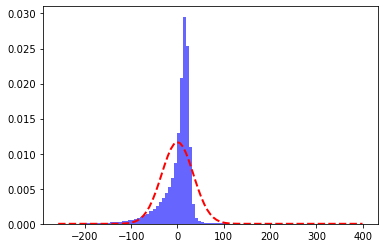

34.2222679272996 0.006885142747784372


In [133]:
import scipy
# ========================= Visualising Errors ========================= #
General_xgbresiduals = y_predict - y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(General_xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(General_xgbresiduals, 100, density=True, facecolor='blue', alpha=0.6)

# add a 'best fit' line
xy = scipy.stats.norm.pdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

# LightGBM

In [134]:
dataset_random=dataset.sample(frac=0.6)

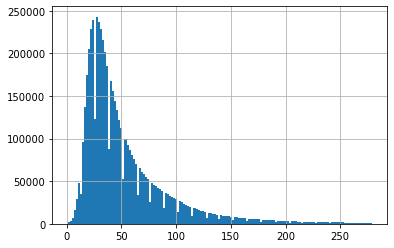

In [135]:
travel_time_deviation = dataset_random.TravelTime.std()

# Filter outliers from the dataset
General_dataset = dataset_random[abs(dataset_random.TravelTime-dataset_random.TravelTime.mean()) < 3*travel_time_deviation]

# Show spread of data
General_dataset.TravelTime.hist(bins=150)

In [136]:
# ========================= Test/Train Splits ========================== #
X_train, X_test, y_train, y_test = train_test_split(General_dataset[predictors],
                                                     General_dataset[target].values.ravel(), 
                                                     test_size=0.3, 
                                                     shuffle=True)
print("original range is: ",General_dataset.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  5552302
training range (70%):	 rows 0 to 3886611
test range (30%): 	 rows 3886611 to 5552302


In [137]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# specify your configurations as a dict
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': {'l2', 'auc'},
'num_leaves': 31,
'learning_rate': 0.05,
'feature_fraction': 0.9,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
#print('Save model...')
# save model to file
#gbm.save_model('lightgbm/model.txt')

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print(y_pred)
#print('The roc of prediction is:', roc_auc_score(y_test, y_pred) )
#print('Dump model to JSON...')
# dump model to json (and save to file)
#model_json = gbm.dump_model()
#with open('lightgbm/model.json', 'w+') as f:
#json.dump(model_json, f, indent=4)
#print('Feature names:', gbm.feature_name())
print('Calculate feature importances...')
# feature importances
print('Feature importances:', list(gbm.feature_importance()))


NameError: name 'lgb' is not defined

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("r2: %.2f%%" % (r2 * 100.0))

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("mse: %.2f%%" % (mse))

In [ ]:
import scipy
# ========================= Visualising Errors ========================= #
General_xgbresiduals = y_pred - y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(General_xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(General_xgbresiduals, 100, density=True, facecolor='blue', alpha=0.6)

# add a 'best fit' line
xy = scipy.stats.norm.pdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

### Stop Wise Models

In [40]:
stop_pairs

,StopPointID,StopPoint_2
0,7347,3669
1,3669,7349
2,7349,1631
3,1631,1632
4,1632,5053
...,...,...
9781627,1347,7347
9782351,194,198
9785484,3677,3679
9794998,827,72


In [50]:
# Training Model for all pairs of stops in the dataset

models = dict()
emptys = []
metric = dict()

no_stops = stop_pairs.count()[0]
print("There are %d models to train." % no_stops)

for pair in tqdm_notebook(stop_pairs.iterrows(), desc="Progress: ", total=no_stops):

    # Travelling From A -> B
    A = pair[1][0]
    B = pair[1][1]
    
    
    # ========================= Rows from A -> B =========================== #
    data = dataset[(dataset.StopPoint_2==B)&(dataset.StopPointID==A)]
    
    if data.count()[0] > 10:
    
        # ========================= Removing Outliers ========================== #
        travel_sigma = data.TravelTime.std()

        # Only allow travel times greater than zero 
        data = data[data.TravelTime >= 0]

        # Filter outliers from the dataset [ 2σ as the cutoff ~95% of data ]
        data = data[abs(data.TravelTime - data.TravelTime.mean()) < 2*travel_sigma]

        # ========================= Remove Null Data =========================== #
        data.dropna(inplace=True)

        # ========================= Test/Train Splits ========================== #
        X_train, X_test, y_train, y_test = train_test_split(data[predictors],data[target].values.ravel(), test_size=0.3, shuffle=True)

        # ========================== Making DMatrices ========================== #
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # =========================== Training Model =========================== #

        param = {
            'eta': 0.15,
            'max_depth': 6
        }

        num_rounds = 10000

        try:
            
            # ============ Train ============= #
            model = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=False, early_stopping_rounds=100)
            models[f'{A}_{B}'] = model
            
            # ============ Testing Accuracy ========== #
            preds = model.predict(dtest)
            metric[f'{A}_{B}'] = dict()
            metric[f'{A}_{B}']['rmse'] = np.sqrt(metrics.mean_squared_error(preds, y_test))
            metric[f'{A}_{B}']['preds']= preds
            metric[f'{A}_{B}']['ytest']= y_test
            
            
        except Exception as e:
            print(f"Error with route: {A} -> {B}")
            data.head()
            y_train, y_test
            print(repr(e), end='\n================================================\n')
    else:
        print(f"Empty Set Error: {A} -> {B}")
        emptys.append((A,B))

There are 8690 models to train.


Empty Set Error: 5171 -> 2979
Empty Set Error: 8 -> 7347
Empty Set Error: 1322 -> 5051
Empty Set Error: 5051 -> 2975
Empty Set Error: 2978 -> 1330
Empty Set Error: 760 -> 2039
Empty Set Error: 404 -> 7340
Empty Set Error: 4253 -> 4306
Empty Set Error: 4306 -> 4257
Empty Set Error: 793 -> 303
Empty Set Error: 2628 -> 2360
Empty Set Error: 3811 -> 3664
Empty Set Error: 4323 -> 4769
Empty Set Error: 6251 -> 1500
Empty Set Error: 3986 -> 3991
Empty Set Error: 1632 -> 1633
Empty Set Error: 761 -> 4571
Empty Set Error: 299 -> 516
Empty Set Error: 261 -> 7229
Empty Set Error: 7623 -> 2278
Empty Set Error: 567 -> 569
Empty Set Error: 3735 -> 7204
Empty Set Error: 760 -> 2008
Empty Set Error: 3126 -> 3283
Empty Set Error: 342 -> 2394
Empty Set Error: 407 -> 2499
Empty Set Error: 396 -> 399
Empty Set Error: 1424 -> 4399
Empty Set Error: 7639 -> 5047
Empty Set Error: 407 -> 354
Empty Set Error: 315 -> 752
Empty Set Error: 5125 -> 4438
Empty Set Error: 1599 -> 1604
Empty Set Error: 137 -> 1529
Emp

In [51]:
# Exporting all models 
    
mkeys = list(models.keys())

for k in tnrange(len(mkeys)):
    
    key = mkeys[k]
    
    models[key].save_model(f"../data_analysis/model/StopModels/{key}.model")